Loading Data    

In [ ]:
!pip install pyLDAvis

In [1]:
# Importing modules
import pandas as pd
import os
import pyLDAvis.gensim
import pickle
import pyLDAvis
from pprint import pprint
import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

# Read data into papers
papers = pd.read_csv('full_context_PeerRead.csv')
# Print head
papers.head()

ModuleNotFoundError: No module named 'pyLDAvis'

Data Cleaning

In [ ]:
# Remove the columns
papers = papers.drop(columns=['source_author', 'source_id',
                              'source_venue', 'target_id', 'target_author',
                              'target_abstract', 'target_year', 'target_title',
                              'target_venue'], axis=1)
# Print out the first rows of papers
papers.head()

Remove punctuation/lower casing (SOURCE ABSTRACT FOCUS)

In [ ]:
# Remove punctuation
papers['paper_text_processed'] = \
papers['source_abstract'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

0    deep neural networks (dnns) are powerful model...
1    syntactic parsing is a fundamental problem in ...
2    we introduce a new neural architecture to lear...
3    the recently introduced continuous skip-gram m...
4    the recently introduced continuous skip-gram m...
Name: paper_text_processed, dtype: object

Exploratory Analysis


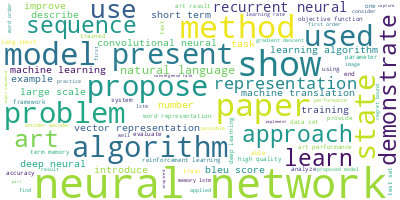

In [ ]:
# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Prepare data for LDA Analysis

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['deep', 'neural', 'networks', 'dnns', 'powerful', 'models', 'achieved', 'excellent', 'performance', 'difficult', 'learning', 'tasks', 'although', 'dnns', 'work', 'well', 'whenever', 'large', 'labeled', 'training', 'sets', 'available', 'cannot', 'used', 'map', 'sequences', 'sequences', 'paper', 'present', 'general']


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 4), (16, 1), (17, 1), (18, 2), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 2), (28, 1), (29, 1)]


LDA model training


In [ ]:
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"model" + 0.014*"learning" + 0.013*"word" + 0.012*"representations" + '
  '0.011*"neural" + 0.009*"networks" + 0.008*"models" + 0.007*"show" + '
  '0.007*"words" + 0.007*"vector"'),
 (1,
  '0.020*"lstm" + 0.012*"neural" + 0.010*"sequence" + 0.009*"bleu" + '
  '0.009*"long" + 0.009*"learning" + 0.008*"deep" + 0.008*"networks" + '
  '0.007*"term" + 0.007*"models"'),
 (2,
  '0.013*"learning" + 0.010*"model" + 0.007*"data" + 0.006*"problem" + '
  '0.006*"using" + 0.006*"method" + 0.006*"show" + 0.006*"algorithms" + '
  '0.006*"based" + 0.005*"algorithm"'),
 (3,
  '0.011*"model" + 0.010*"neural" + 0.010*"method" + 0.009*"models" + '
  '0.009*"network" + 0.008*"training" + 0.008*"networks" + 0.007*"based" + '
  '0.007*"also" + 0.006*"data"')]


Analyzing LDA model results


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./lda_modeling'+str(num_topics))

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './lda_modeling'+ str(num_topics) +'.html')
LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.